Number of gates in the circuit: 31


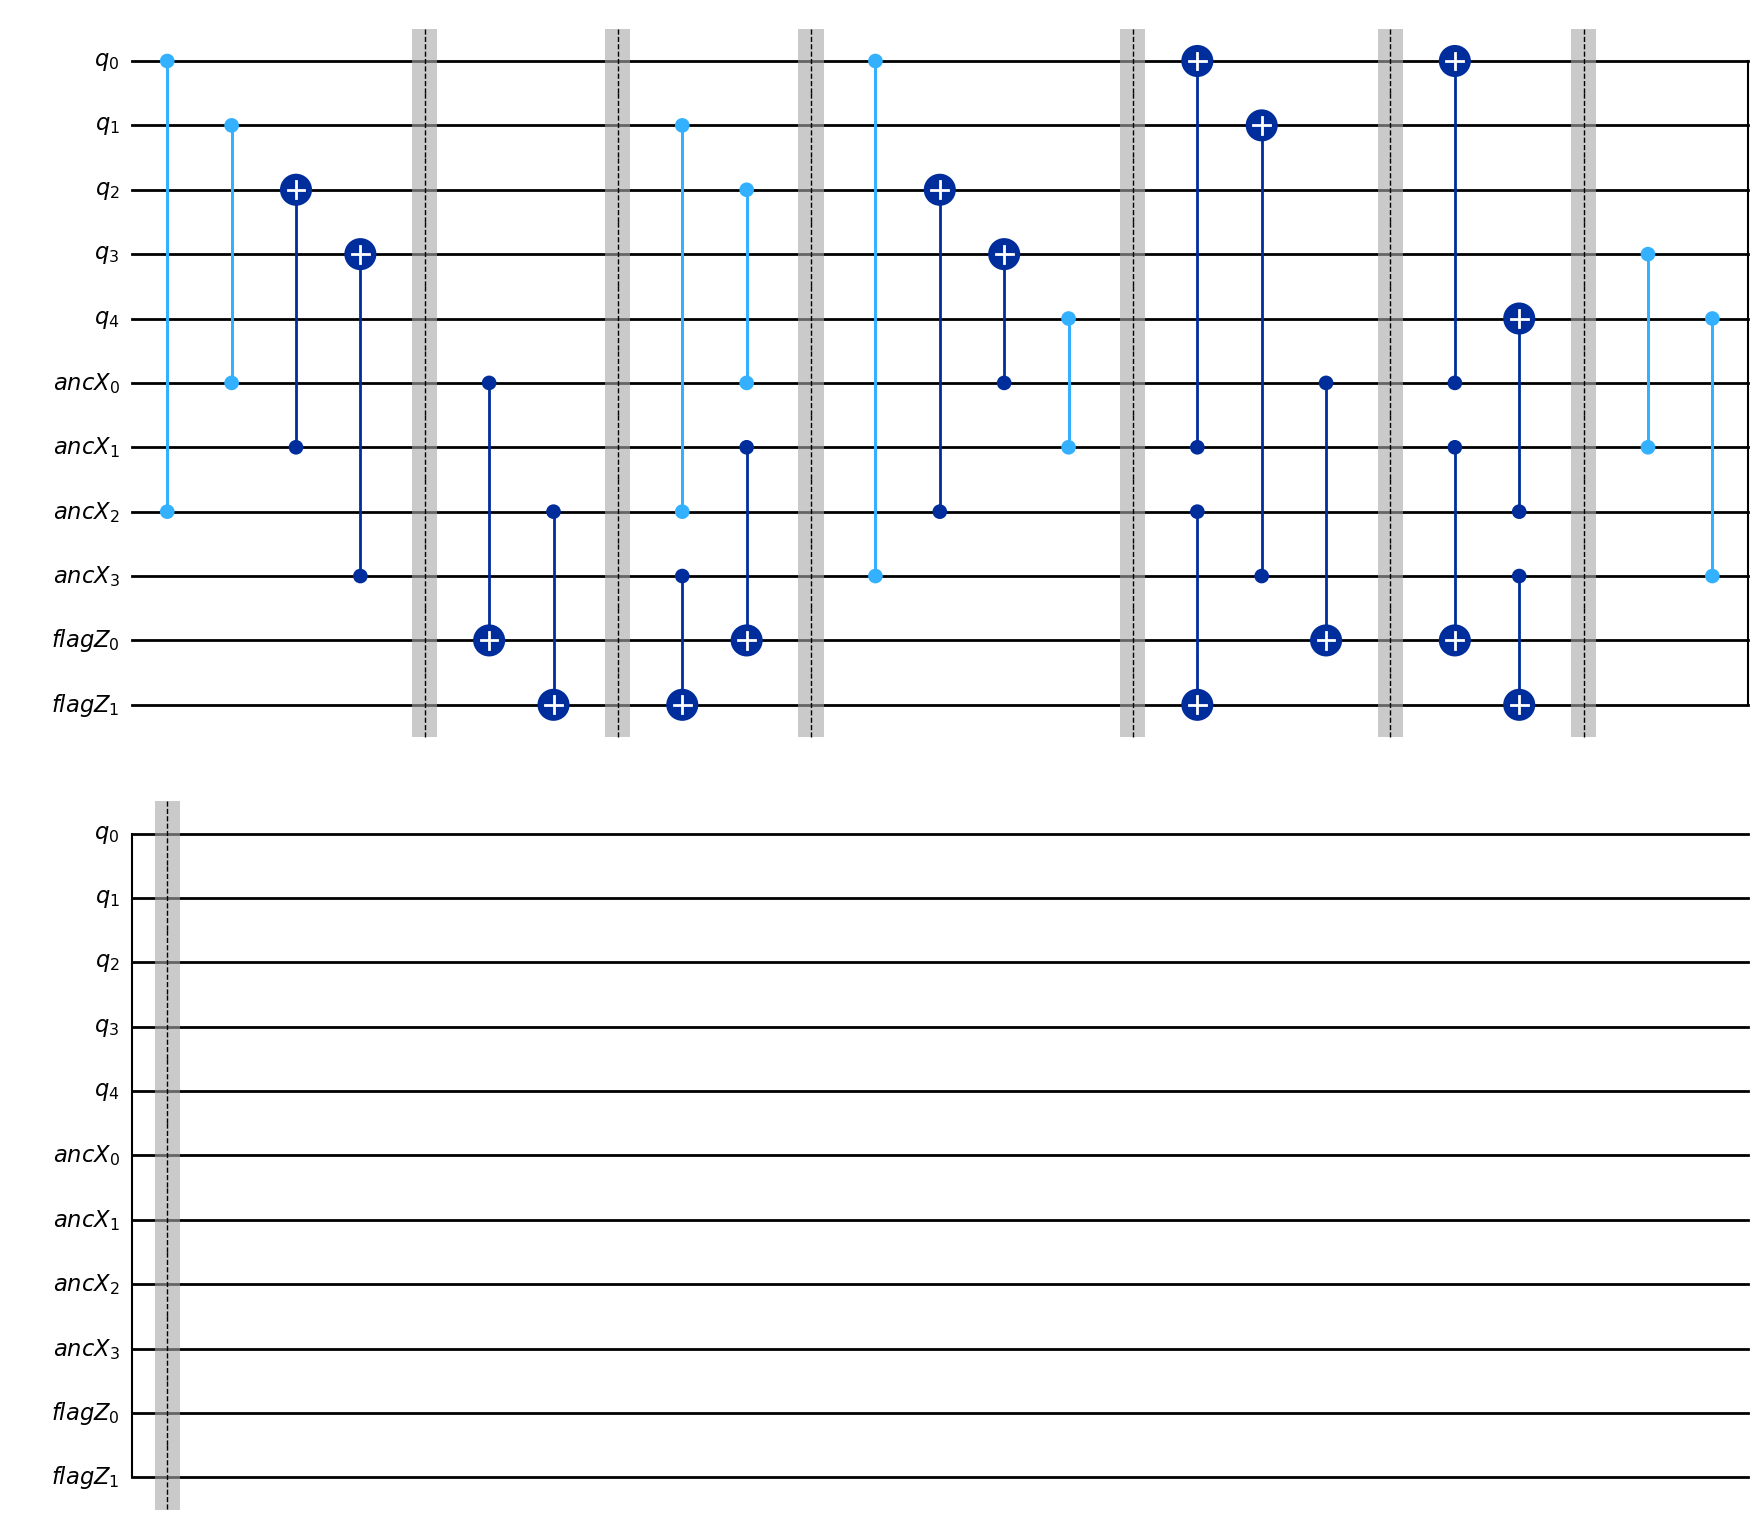

In [1]:
from qiskit import QuantumCircuit
from flag_analysis import *

dir_path = "/Users/wuboris/Desktop/flag verification/[[5,1,3]]_[2,2]_T/"
qasm_path = dir_path + "[[5,1,3]]_flag_[2,2]_T.qasm"
txt_path = dir_path + "[[5,1,3]]_[2,2]_T.txt"
# Load circuit from QASM file
qc = QuantumCircuit.from_qasm_file(qasm_path)


num_gates = sum(1 for inst in qc.data )
print(f"Number of gates in the circuit: {num_gates}")
# Draw the circuit (matplotlib drawer)
qc.draw("mpl", filename= dir_path + "[[5,1,3]]_flag.png")



In [2]:
from flag_analysis import *
# Build
state, qc, varenv = build_variable_state_from_qasm(qasm_path)
groups = detect_qubit_groups(qc)

# Flip predicates (basis-aware)
synX_exprs = ancillas_X(state, groups["ancX"])   # X-type syndromes (check .z)
synZ_exprs = ancillas_Z(state, groups["ancZ"])   # Z-type syndromes (check .x)
flgX_exprs = flags_X(state, groups["flagX"])     # flags measured in X (check .z)
flgZ_exprs = flags_Z(state, groups["flagZ"])     # flags measured in Z (check .x)

# Build an assignment:
# - allow arbitrary data errors via named vars (you can set a subset True)
# - force all anc/flag variables to False to model "no circuit faults"
asgmt = {}

# Force all anc/flag vars False:
for name in varenv:
    if name.startswith("ancX") or name.startswith("ancZ") or name.startswith("flagX") or name.startswith("flagZ"):
        asgmt[name] = False

# Example 1: single X error on q[3]  (Steane’s first X-stabilizer should click)

# (all other q*_x/z default to False)

# Evaluate syndromes/flags
synX_vals = [eval_under(e, asgmt, varenv) for e in synX_exprs]
synZ_vals = [eval_under(e, asgmt, varenv) for e in synZ_exprs]
flgX_vals = [eval_under(e, asgmt, varenv) for e in flgX_exprs]
flgZ_vals = [eval_under(e, asgmt, varenv) for e in flgZ_exprs]

print("AncX (X-type) syndromes:", synX_vals)
print("AncZ (Z-type) syndromes:", synZ_vals)
print("Flags X-basis:", flgX_vals)
print("Flags Z-basis:", flgZ_vals)

AncX (X-type) syndromes: [Not(((q2_x == q1_x) == q3_z) == q0_z), Not(q3_x == ((q4_x == q2_z) == q0_z)), Not(((q1_x == q0_x) == q2_z) == q4_z), Not(q4_x == ((q0_x == q3_z) == q1_z))]
AncZ (Z-type) syndromes: []
Flags X-basis: []
Flags Z-basis: [False, False]


In [3]:
# Build circuit state first, to get varenv with q{i}_x/z
state, qc, varenv = build_variable_state_from_qasm(qasm_path)

#print("varenv:", varenv)
# Load stabilizers
stabs = load_symplectic_txt(txt_path)
#print("Stabilizers:", stabs)
# Get Boolean formulas
stab_exprs = [anticomm_formula(Sx, Sz, varenv) for Sx,Sz in stabs]

for i, e in enumerate(stab_exprs):
    print(f"Stabilizer {i} formula:", e)



Stabilizer 0 formula: Xor(Xor(Xor(Xor(False, q0_z), q1_x), q2_x), q3_z)
Stabilizer 1 formula: Xor(Xor(Xor(Xor(False, q0_z), q2_z), q3_x), q4_x)
Stabilizer 2 formula: Xor(Xor(Xor(Xor(False, q0_x), q1_x), q2_z), q4_z)
Stabilizer 3 formula: Xor(Xor(Xor(Xor(False, q0_x), q1_z), q3_z), q4_x)


In [4]:
from flag_analysis import check_ancillas_match_symplectic_ordered

report = check_ancillas_match_symplectic_ordered(
    qasm_path,
    txt_path,
    order="X-then-Z"   # change to "Z-then-X" if your .txt lists Z-first
)

print("OK?", report["ok"])

print("Mismatches:", report["mismatches"])

OK? True
Mismatches: []


In [5]:
from flag_analysis import *
from functools import reduce

bad_locations_dict = [] # List to store bad locations for the current circuit



for i in range(num_gates):  # Iterate over gates in the subcircuit
    
    circuit_bad_locations = []
    if qc.data[i].name  in ["barrier", "measure", "reset"]:
        continue  # Skip non-unitary gates

    
    state, qc, site_info, groups = build_state_with_fault_after_gate(
           qasm_path,
        gate_index=i,
        fault_mode="2q"
    )
    
    # Extract fault variables
    fault_var = [v for k, v in site_info["vars"].items() if k.startswith("f")]

    # Extract qubit groups
    data_idxs = groups["data"]
    ancz_idxs = groups["ancZ"]
    flagx_idxs = groups["flagX"]
    ancx_idxs = groups["ancX"]
    flagz_idxs = groups["flagZ"]

    # Extract error components
    E_x = [state.qubits[i].x for i in data_idxs]
    E_z = [state.qubits[i].z for i in data_idxs]

    
    # Build stabilizer-equivalent errors
    Epx, Epz, gsel = build_stab_equiv_errors(E_x, E_z, txt_path)

    # Build per-qubit error indicators
    b = [Or(xi, zi) for xi, zi in zip(Epx, Epz)]

    # Create a Z3 solver
    from z3 import Solver, Or, PbLe, ForAll, Xor, Implies, Exists
    s = Solver()
    s.add(ForAll(fault_var, Implies(Or(fault_var), Exists(gsel, PbLe([(bi, 1) for bi in b], 1)))))
    
    
    

    # Check satisfiability
    print("i ", i, s.check())
    if s.check() == unsat:
        print("Bad location found at gate index:", i)
        print("qc.instructions ", qc.data[i].name, qc.data[i].qubits)
    
        # Store bad locations and gate numbers for the current subcircuit
        bad_locations_dict.append(i)

# Update the gate count for the next subcircuit




# Print the results
print("Bad locations:")
print(bad_locations_dict)


    

i  0 sat
i  1 sat
i  2 sat
i  3 sat
i  5 sat
i  6 sat
i  8 unsat
Bad location found at gate index: 8
qc.instructions  cz (<Qubit register=(5, "q"), index=1>, <Qubit register=(4, "ancX"), index=2>)
i  9 sat
i  10 unsat
Bad location found at gate index: 10
qc.instructions  cz (<Qubit register=(5, "q"), index=2>, <Qubit register=(4, "ancX"), index=0>)
i  11 sat
i  13 unsat
Bad location found at gate index: 13
qc.instructions  cz (<Qubit register=(5, "q"), index=0>, <Qubit register=(4, "ancX"), index=3>)
i  14 unsat
Bad location found at gate index: 14
qc.instructions  cx (<Qubit register=(4, "ancX"), index=2>, <Qubit register=(5, "q"), index=2>)
i  15 unsat
Bad location found at gate index: 15
qc.instructions  cx (<Qubit register=(4, "ancX"), index=0>, <Qubit register=(5, "q"), index=3>)
i  16 unsat
Bad location found at gate index: 16
qc.instructions  cz (<Qubit register=(5, "q"), index=4>, <Qubit register=(4, "ancX"), index=1>)
i  18 unsat
Bad location found at gate index: 18
qc.instruc

In [ ]:
###################################
#####check if the flag raised######
###################################
for i in range(1):  # Iterate over stabilizers (subcircuits)
    
    state, qc, sites_info, groups = build_state_with_faults_after_gates(qasm_path ,bad_locations_dict, fault_mode="2q")    
    #print(sites_info)

    data_idxs = groups["data"]
    ancz_idxs = groups["ancZ"]
    flagx_idxs = groups["flagX"]
    ancx_idxs = groups["ancX"]
    flagz_idxs = groups["flagZ"]


    fault_var = [[v for k,v in s["vars"].items() if k.startswith("f")] for s in sites_info]
    print("Injected fault variables:", fault_var)


    all_fault_vars = [f for sublist in fault_var for f in sublist]
    acts = [s["act"] for s in sites_info]
    print("Active fault sites:", acts)
    #print("Data qubits:", data_idxs)
    #print("Ancilla qubits (Z-basis):", anc_idxs)
    #print("Flag qubits (X-basis):", flag_idxs)

    E_x = [state.qubits[i].x for i in data_idxs]
    E_z = [state.qubits[i].z for i in data_idxs]

    if groups["flagX"] != []: F = [state.qubits[i].z for i in groups["flagX"]]
    elif groups["flagZ"] != []: F = [state.qubits[i].x for i in groups["flagZ"]]
    else: print("No flag qubits found.")


    print("flag :", F)

    Epx, Epz, gsel = build_stab_equiv_errors(E_x, E_z,txt_path)
    b= [Or(xi, zi) for xi, zi in zip(Epx, Epz)]

    s = Solver()
    # Add the constraint to the solver
    s.add(ForAll(all_fault_vars, Implies(
        And(
            Not(Exists(gsel, PbLe([(bi, 1) for bi in b], 1))),
            AtMost(*acts,1 ),
        ),
        Or(F)  # Combine F_z into a single condition if it's a list
    )))

    print(s.check())


groups detected: {'data': [0, 1, 2, 3, 4], 'ancX': [5, 6, 7, 8], 'ancZ': [], 'flagX': [], 'flagZ': [9, 10]}
Processing gate 0: cz on qubits [0, 7]
Processing gate 1: cz on qubits [1, 5]
Processing gate 2: cx on qubits [6, 2]
Processing gate 3: cx on qubits [8, 3]
Processing gate 4: barrier on qubits [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Processing gate 5: cx on qubits [5, 9]
Processing gate 6: cx on qubits [7, 10]
Processing gate 7: barrier on qubits [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Processing gate 8: cz on qubits [1, 7]
Processing gate 9: cx on qubits [8, 10]
Processing gate 10: cz on qubits [2, 5]
Processing gate 11: cx on qubits [6, 9]
Processing gate 12: barrier on qubits [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Processing gate 13: cz on qubits [0, 8]
Processing gate 14: cx on qubits [7, 2]
Processing gate 15: cx on qubits [5, 3]
Processing gate 16: cz on qubits [4, 6]
Processing gate 17: barrier on qubits [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Processing gate 18: cx on qubits [6, 0]
Processi

In [7]:

print("Bad locations:")
print(bad_locations_dict)


Bad locations:
[8, 10, 13, 14, 15, 16, 18, 19]


Original gates: 23


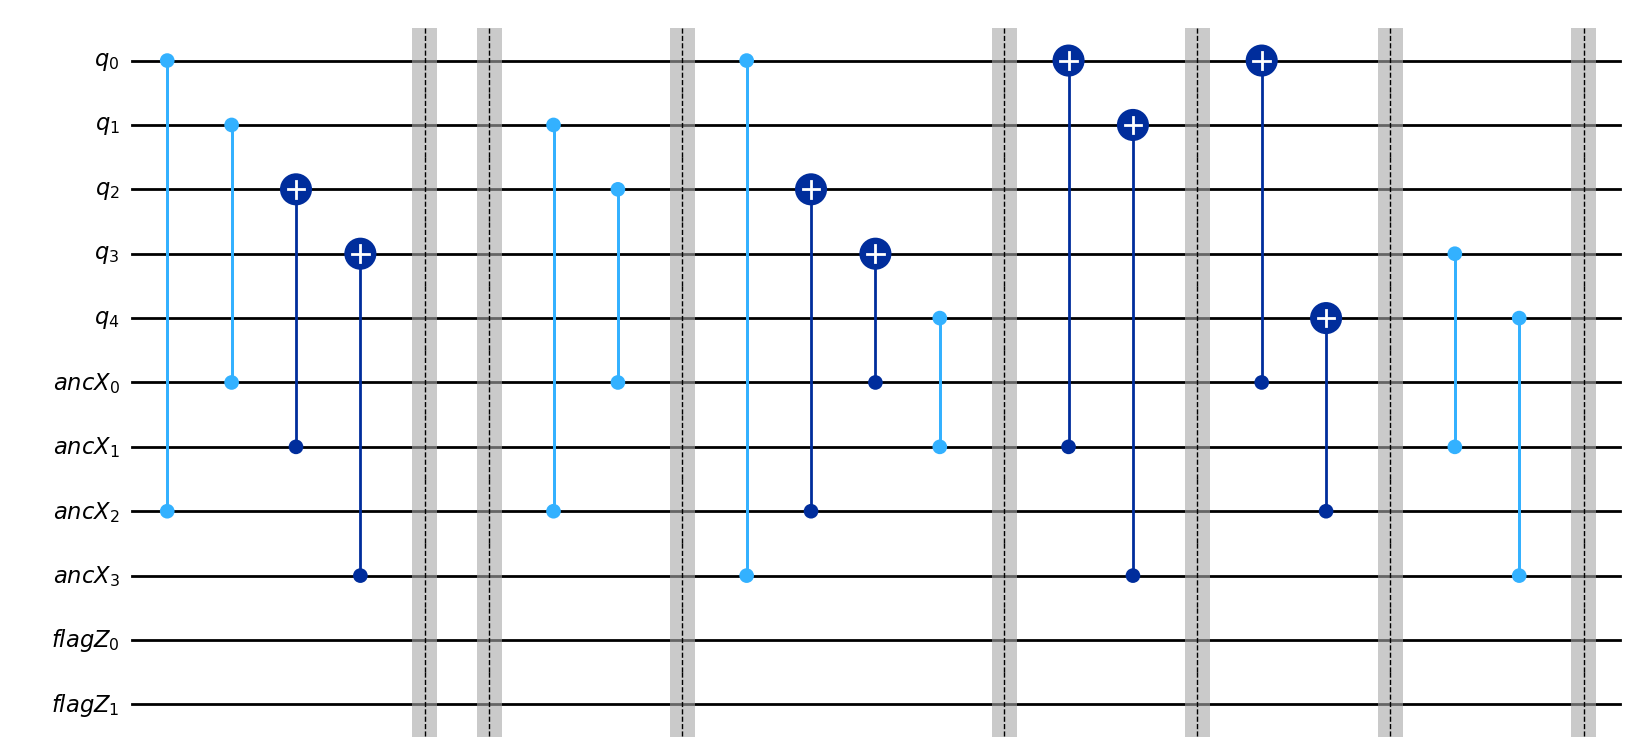

In [8]:
clean_qc = remove_flag_gates(qasm_path, save_path=dir_path + "[[5,1,3]]_[2,2]_T_no_flag.qasm")
print("Original gates:", len(clean_qc.data))
clean_qc.draw("mpl")



In [9]:
from z3 import PbGe
state, qc, sites_info, groups = build_state_with_faults_after_gates( qasm_path,bad_locations_dict, fault_mode="2q")   
#print(sites_info)
data_idxs = groups["data"]
ancz_idxs = groups["ancZ"]
flagx_idxs = groups["flagX"]
ancx_idxs = groups["ancX"]
flagz_idxs = groups["flagZ"]

print("Data qubits:", data_idxs)
print("Ancilla qubits (Z-basis):", ancz_idxs)
print("Ancilla qubits (X-basis):", ancx_idxs)
print("Flag qubits (X-basis):", flagx_idxs)
print("Flag qubits (Z-basis):", flagz_idxs)

after_flag_state_X = [state.qubits[i].x for i in data_idxs]
after_flag_state_Z = [state.qubits[i].z for i in data_idxs]

fault_var = [[v for k,v in s["vars"].items() if k.startswith("f")] for s in sites_info]
gate_fault_constr = [Or(f) for f in fault_var if f != []]



flag_err_var =  []

flag_err_var.extend(inject_on_flags(state, flagx_idxs, axis="z", prefix="flagErr"))


flag_err_var.extend(inject_on_flags(state, flagz_idxs, axis="x", prefix="flagErr"))
print("flagz_idxs", flagz_idxs)
print("flag_err_var", flag_err_var)
anc_err_var = [] 

anc_err_var.extend(inject_on_flags(state, ancx_idxs, axis="z", prefix="ancErr"))
anc_err_var.extend(inject_on_flags(state, ancz_idxs, axis="x", prefix="ancErr"))

all_fault = gate_fault_constr+ flag_err_var + anc_err_var

one_fault_constr = [ And (PbGe( [(f,1) for f in all_fault], 1), PbLe( [(f,1) for f in all_fault], 1))]



var = [sub for sub in fault_var for sub in sub] + flag_err_var + anc_err_var

ren_1 = make_renamer_from_symbols(var, "_p1")
ren_2 = make_renamer_from_symbols(var, "_p2")

one_fault_constr_p1 = primed_copy(one_fault_constr, ren_1)
one_fault_constr_p2 = primed_copy(one_fault_constr, ren_2)

print("one_fault_constr_p1", one_fault_constr_p1)
print("one_fault_constr_p2", one_fault_constr_p2)


A = [state.qubits[i].z for i in ancx_idxs] + [state.qubits[i].x for i in ancz_idxs]
F = [state.qubits[i].z for i in flagx_idxs] + [state.qubits[i].x for i in flagz_idxs]

print("Flag expr")


A_1 = primed_copy(A, ren_1)
A_2 = primed_copy(A, ren_2)
F_1 = primed_copy(F, ren_1)
F_2 = primed_copy(F, ren_2)

after_raw_state, snap = symbolic_propagate_with_resets(clean_qc ,state, track_steps= True)

E_x = [after_raw_state.qubits[i].x for i in data_idxs]
E_z = [after_raw_state.qubits[i].z for i in data_idxs]

raw_A = [after_raw_state.qubits[i].z for i in ancx_idxs] + [after_raw_state.qubits[i].x for i in ancz_idxs]

E_x_1 = primed_copy(E_x, ren_1)
E_z_1 = primed_copy(E_z, ren_1)
E_x_2 = primed_copy(E_x, ren_2)
E_z_2 = primed_copy(E_z, ren_2)

raw_A_1 = primed_copy(raw_A, ren_1)
raw_A_2 = primed_copy(raw_A, ren_2)

gen_syn_1 = A_1 + F_1 + raw_A_1
gen_syn_2 = A_2 + F_2 + raw_A_2


stab_eq , gsel = exists_stab_equiv(E_x_1, E_z_1, E_x_2, E_z_2, txt_path)




same_syn =  And( *[x == y for x, y in zip(gen_syn_1, gen_syn_2)] )
s = Solver()
s.add(same_syn, Not(Exists(gsel, stab_eq)))
s.add(one_fault_constr_p1)
s.add(one_fault_constr_p2)


print(s.check()) 


groups detected: {'data': [0, 1, 2, 3, 4], 'ancX': [5, 6, 7, 8], 'ancZ': [], 'flagX': [], 'flagZ': [9, 10]}
Processing gate 0: cz on qubits [0, 7]
Processing gate 1: cz on qubits [1, 5]
Processing gate 2: cx on qubits [6, 2]
Processing gate 3: cx on qubits [8, 3]
Processing gate 4: barrier on qubits [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Processing gate 5: cx on qubits [5, 9]
Processing gate 6: cx on qubits [7, 10]
Processing gate 7: barrier on qubits [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Processing gate 8: cz on qubits [1, 7]
Processing gate 9: cx on qubits [8, 10]
Processing gate 10: cz on qubits [2, 5]
Processing gate 11: cx on qubits [6, 9]
Processing gate 12: barrier on qubits [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Processing gate 13: cz on qubits [0, 8]
Processing gate 14: cx on qubits [7, 2]
Processing gate 15: cx on qubits [5, 3]
Processing gate 16: cz on qubits [4, 6]
Processing gate 17: barrier on qubits [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Processing gate 18: cx on qubits [6, 0]
Processi

In [10]:
i = 2
step = snap[i]           # pick which gate step you want
state = step[3]               # the CircuitXZ object
qubit_index = 6
print("step", step[0], "gate:", step[1], "qubits:", step[2])
print("Qubit", qubit_index, f"state at step {i}:", state.qubits[qubit_index])

step 2 gate: cx qubits: (6, 2)
Qubit 6 state at step 2: QubitXZ(x=False, z=Xor(False,
    Xor(Xor(Xor(False, False), faulty_gate10_z0),
        faulty_gate14_z1)))


In [11]:
for d in s.model().decls(): 
    
    val = s.model()[d]
    if str(val)  == "True": 
        print(f"{d.name()} = {val}")


faulty_gate14_x0_p2 = True
faulty_gate14_z1_p2 = True
faulty_gate19_z0_p1 = True
faulty_gate19_x0_p1 = True
faulty_gate19_z1_p1 = True


In [12]:


val_1 =  { "faulty_gate8_x1" : True}
val_2 =   {"faulty_gate14_x0" : True, "faulty_gate14_z1" : True}
for i in range(len(A)): 
    print(f"A_{i}", eval_with_values(A[i], val_1),  eval_with_values(A[i], val_2))
for i in range(len(F)): 
    print(f"F_{i}", eval_with_values(F[i], val_1), eval_with_values(F[i], val_2))

for i in range(len(raw_A)): 
    print(f"raw_A_{i}", eval_with_values(raw_A[i], val_1) , eval_with_values(raw_A[i], val_2))

A_0 False False
A_1 False False
A_2 False False
A_3 True True
F_0 False False
F_1 True True
raw_A_0 True False
raw_A_1 True False
raw_A_2 False True
raw_A_3 True True


In [13]:


val_1 =  {"faulty_gate8_x1_p1" : True}
val_2 =   {"faulty_gate14_x0_p2" : True, "faulty_gate14_z1_p2" : True}

for E in E_x_1:
    print("E_x_1", E)
    val  = eval_with_values(E, val_1)
    print("E_x_1", val)

for E in E_z_1:
    val  = eval_with_values(E, val_1)
    print("E_z_1", val)

for E in E_x_2:
   val  = eval_with_values(E, val_2)
   print("E_x_2", val)

for E in E_z_2:
   val  = eval_with_values(E, val_2)
   print("E_z_2", val)


for A in A_1:
    val  = eval_with_values(A, val_1)
    print("A_1", val)


for F in F_1:
    print("F", F)
    val  = eval_with_values(F, val_1)
    print("F_1", val)

for A in A_2:
    val  = eval_with_values(A, val_2)
    print("A_2", val)
for F in F_2:
    val  = eval_with_values(F, val_2)
    print("F_2", val)

for raw_A in raw_A_1:
    val  = eval_with_values(raw_A, val_1)
    print("raw_A_1", val)

for raw_A in raw_A_2:
    val  = eval_with_values(raw_A, val_2)
    print("raw_A_2", val)


E_x_1 Xor(Xor(Xor(Xor(Xor(Xor(False, faulty_gate13_x0_p1),
                    Xor(False, faulty_gate16_x1_p1)),
                faulty_gate18_x1_p1),
            Xor(Xor(False, faulty_gate10_x1_p1),
                faulty_gate15_x0_p1)),
        False),
    False)
E_x_1 False
E_x_1 Xor(Xor(Xor(Xor(False, faulty_gate8_x0_p1),
            Xor(False, faulty_gate13_x1_p1)),
        faulty_gate19_x1_p1),
    False)
E_x_1 False
E_x_1 Xor(Xor(Xor(Xor(Xor(Xor(False, False), faulty_gate10_x0_p1),
                Xor(False, faulty_gate8_x1_p1)),
            faulty_gate14_x1_p1),
        False),
    False)
E_x_1 True
E_x_1 Xor(Xor(Xor(Xor(Xor(False, False),
                Xor(False, faulty_gate10_x1_p1)),
            faulty_gate15_x1_p1),
        False),
    False)
E_x_1 False
E_x_1 Xor(Xor(Xor(False, faulty_gate16_x0_p1),
        Xor(Xor(False, faulty_gate8_x1_p1),
            faulty_gate14_x0_p1)),
    False)
E_x_1 True
E_z_1 False
E_z_1 False
E_z_1 False
E_z_1 False
E_z_1 False
E_x_2 False
E

In [10]:
# ---------- helper: evaluate z3 Bool expr(s) under a partial assignment ----------
from z3 import Bool, BoolVal, simplify, substitute, is_true

def eval_with_values(exprs, assignment, default_false=True):
    """
    Evaluate Z3 Bool expr(s) under dict name->bool.
    Missing vars default to False iff default_false=True.
    """
    def _eval_one(e):
        subs = []
        # substitute given vars
        for k, v in assignment.items():
            subs.append((Bool(k), BoolVal(v)))
        # optionally ground all *other* variables in e to False
        if default_false:
            # A conservative sweep: try substituting any unknown symbol by name.
            # This is crude but works well for pure-Bool formulas.
            seen = set(assignment.keys())
            stack = [e]
            names_to_false = set()
            while stack:
                node = stack.pop()
                for ch in node.children():
                    stack.append(ch)
                # z3 prints var names as strings when str()'d
                s = str(node)
                if s.isidentifier() and s not in seen and s not in names_to_false:
                    names_to_false.add(s)
            for nm in names_to_false:
                subs.append((Bool(nm), BoolVal(False)))
        val = simplify(substitute(e, subs))
        return bool(is_true(val))
    if isinstance(exprs, (list, tuple)):
        return [_eval_one(e) for e in exprs]
    return _eval_one(exprs)

# ---------- sweep all g0..g3 for a fixed fault ----------
from itertools import product

def sweep_g_cases_for_fault(b_list, fault_name="faulty_gate16_x1", F_list=None, default_false=True):
    """
    b_list : list[BoolRef]  (your data-qubit error indicators)
    fault_name : the single fault variable to set True (others default False)
    F_list : optional list[BoolRef] of flag flip bits; if given, prints flags=Or(F_list)
    """
    rows = []
    g_names = ["g0", "g1", "g2", "g3"]
    for bits in product([False, True], repeat=len(g_names)):
        asgmt = {fault_name: True}
        asgmt.update({n: v for n, v in zip(g_names, bits)})
        b_vals = eval_with_values(b_list, asgmt, default_false=default_false)
        weight = sum(b_vals)
        le1 = (weight <= 1)
        if F_list is not None:
            flags_val = any(eval_with_values(F_list, asgmt, default_false=default_false))
        else:
            flags_val = None
        rows.append((tuple(bits), b_vals, weight, le1, flags_val))
    return rows

def pretty_print_rows(rows, show_flags=True):
    for g_bits, b_vals, wt, le1, flags in rows:
        line = f"g={g_bits} -> b={b_vals}, weight={wt}, sum(b)<=1? {le1}"
        if show_flags and flags is not None:
            line += f", flags={flags}"
        print(line)

# ---------- HOW TO USE ----------
# 1) Ensure `b` is your list of 5 BoolRefs (as you showed), built in your session.
# 2) Optionally define F (e.g., F=[F0, F1]) if you want to report flags.

# Example call (adjust names to your session):
# rows = sweep_g_cases_for_fault(b, fault_name="faulty_gate16_x1", F_list=F, default_false=True)
# pretty_print_rows(rows)

In [11]:
rows = sweep_g_cases_for_fault(b, fault_name="faulty_gate8_x1", default_false=True)
pretty_print_rows(rows)

g=(False, False, False, False) -> b=[False, False, True, False, True], weight=2, sum(b)<=1? False
g=(False, False, False, True) -> b=[True, True, True, True, True], weight=5, sum(b)<=1? False
g=(False, False, True, False) -> b=[True, True, False, False, False], weight=2, sum(b)<=1? False
g=(False, False, True, True) -> b=[False, True, False, True, True], weight=3, sum(b)<=1? False
g=(False, True, False, False) -> b=[True, False, False, True, True], weight=3, sum(b)<=1? False
g=(False, True, False, True) -> b=[True, True, False, True, True], weight=4, sum(b)<=1? False
g=(False, True, True, False) -> b=[True, True, True, True, True], weight=5, sum(b)<=1? False
g=(False, True, True, True) -> b=[True, True, True, True, False], weight=4, sum(b)<=1? False
g=(True, False, False, False) -> b=[True, True, True, True, True], weight=5, sum(b)<=1? False
g=(True, False, False, True) -> b=[True, True, True, False, True], weight=4, sum(b)<=1? False
g=(True, False, True, False) -> b=[True, False, True